In [1]:
!bash /home/azureuser/cloudfiles/code/blobfuse/blobfuse_raadsinformatie.sh

In [2]:
import sys
sys.path.append("..")

# Select where to run notebook: "azure" or "local"
my_run = "azure"

import my_secrets as sc
import settings as st

if my_run == "azure":
    import config_azure as cf
elif my_run == "local":
    import config as cf


import os
if my_run == "azure":
    if not os.path.exists(cf.HUGGING_CACHE):
        os.mkdir(cf.HUGGING_CACHE)
    os.environ["TRANSFORMERS_CACHE"] = cf.HUGGING_CACHE

import pandas as pd
# setup environment GEITje-7B Finetuning
# - pip install torch
# - pip install datasets
# - pip install transformers
# - pip install trl
# - pip install accelerate (restart after)
# - switch device_map='auto' to avaoid memory error

# - pip install sentencepiece
# - pip install jupyter
# - pip install protobuf 



### Notebook Overview
Goal: analyse the baselines, understand why they work so well

In [31]:
logreg = pd.read_pickle(f"{cf.output_path}/predictionsFinal/baselines/LogisticRegressionpredictions.pkl")
linsvc = pd.read_pickle(f"{cf.output_path}/predictionsFinal/baselines/LinearSVCpredictions.pkl")
nb = pd.read_pickle(f"{cf.output_path}/predictionsFinal/baselines/MultinomialNBpredictions.pkl")

overview = pd.read_pickle(f"{cf.output_path}/predictionsFinal/baselines/overview.pkl")

predictions = pd.concat([logreg, linsvc, nb])


In [32]:
from transformers import AutoTokenizer
from collections import Counter
from sklearn.metrics import classification_report
import sys
sys.path.append('../src/') 
import prompt_template as pt
import warnings
warnings.simplefilter('ignore')


import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def percentage_mistakes(count):
    return f"{round(count/1100*100,1)}%"

def mistakes(df, detailed=False):
    print('MISTAKES. INCLUDES PREDICTIONS ERRORS.')

    # select all response where the prediction was not correct
    mistakes = df.loc[df['label'] != df['prediction']]

    # groupby run_id so we get the amount of mistakes per run
    mistakes_per_run = mistakes.groupby('run_id').size().reset_index(name='count')
    mistakes_per_run['percentage of total predictions'] = mistakes_per_run['count'].apply(percentage_mistakes)
    print("Total amount of mistakes per run:")
    display(mistakes_per_run)

    # for each run get the amount of mistakes per class
    df_count_class = pd.DataFrame(columns=pt.get_class_list())
    for run_id in set(mistakes['run_id']):
        # select mistakes of current runid
        subdf = mistakes.loc[mistakes['run_id']==run_id]
        # count mistakes per class
        class_count = dict(Counter(subdf['label']))

        # if a class is not included in mistakes, set counter to 0
        for category in pt.get_class_list():
            if category not in class_count.keys():
                class_count[category] = 0

        # add count of class to df
        df_count_class.loc[len(df_count_class)] = class_count

    # reset index to runids
    df_count_class.index = list(set(mistakes['run_id']))
    print("Amount of mistakes per class for each run:")
    display(df_count_class)

    # For each run get for each class the highest mistakes
    df_highest_class = pd.DataFrame(columns=pt.get_class_list())
    for run_id in set(mistakes['run_id']):
        # select mistakes of current runid
        subdf = mistakes.loc[mistakes['run_id']==run_id]
        # count mistakes of runid
        count_mistakes_per_class = dict(Counter(subdf['label']))

        class_count = subdf.groupby('label')['prediction'].value_counts().reset_index(name='count')
        highest_per_class = dict()
        for label in set(class_count['label']):
            # for each class select the class for which it made the most mistakes
            highest_count_row = class_count.iloc[class_count[class_count['label'] == label]['count'].idxmax()]
            highest_per_class[label] = f"{highest_count_row['prediction']} ({highest_count_row['count']} out of {count_mistakes_per_class[label]})"

        # add to df
        df_highest_class.loc[len(df_highest_class)] = highest_per_class
    # reset index to run_id
    df_highest_class.index = list(set(mistakes['run_id']))
    print("Highest mistakes per class for each run:")
    display(df_highest_class.transpose())


def predictions_per_class(df):
    df_predictions_per_class = pd.DataFrame(columns=pt.get_class_list())
    for run_id in set(df['run_id']):
        subdf = df.loc[df['run_id']==run_id]
        count_predictions = dict(Counter(subdf['prediction']))
        df_predictions_per_class.loc[len(df_predictions_per_class)] = count_predictions

    df_predictions_per_class.index = list(set(df['run_id']))
    display(df_predictions_per_class.transpose())


def plot_confusion_matrix(df):
    run_ids = sorted(list(set(df['run_id'])))

    # Ensure all classes are included
    class_labels = list(set(df['prediction']) | set(df['label']))
    label_encoder = LabelEncoder()
    label_encoder.fit(class_labels)

    num_run_ids = len(run_ids)
    num_cols = 2
    num_rows = (num_run_ids + num_cols - 1) // num_cols  # Ceiling division to get the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()

    for idx, run_id in enumerate(run_ids):
        subdf = df.loc[df['run_id'] == run_id]
        y_true_labels = subdf['label']
        y_true = label_encoder.transform(y_true_labels)
        y_pred_labels = subdf['prediction']
        y_pred = label_encoder.transform(y_pred_labels)

        class_names = label_encoder.classes_

        cm = confusion_matrix(y_true, y_pred)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[idx])
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')
        axes[idx].set_title(f'Confusion Matrix for run_id {run_id}')

    # Hide any unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


def calculate_avg_cos_sim(df, class1, class2):
    run_ids = sorted(list(set(df['run_id'])))
    
    for run_id in run_ids:
        subdf = df.loc[df['run_id']== run_id]

        # Example texts for each class
        class1_texts = list(subdf.loc[subdf['label']==class1]['trunc_txt'])
        class2_texts = list(subdf.loc[subdf['label']==class2]['trunc_txt'])

        # Combine all texts
        all_texts = class1_texts + class2_texts

        # Initialize TF-IDF vectorizer
        tfidf_vectorizer = TfidfVectorizer()

        # Compute TF-IDF vectors for all texts
        tfidf_vectors = tfidf_vectorizer.fit_transform(all_texts)

        # Calculate cosine similarity between all pairs of TF-IDF vectors
        cosine_similarities = cosine_similarity(tfidf_vectors)

        # Calculate average cosine similarity between texts of class 1 and class 2
        num_class1 = len(class1_texts)
        num_class2 = len(class2_texts)
        total_cosine_similarity = 0

        for i in range(num_class1):
            for j in range(num_class1, num_class1 + num_class2):
                total_cosine_similarity += cosine_similarities[i][j]

        average_cosine_similarity = total_cosine_similarity / (num_class1 * num_class2)

        print(f"{run_id}: Average cosine similarity between texts of {class1} and {class2}:", average_cosine_similarity)


In [33]:
display(overview.loc[overview['run_id'].isin(pred['run_id'])])

,model,date,run_id,train_set,test_set,train_set_support,test_set_support,split_col,text_col,runtime,accuracy,macro_avg_precision,macro_avg_recall,macro_avg_f1,classification_report,weighted_avg_precision,weighted_avg_recall,weighted_avg_f1
0,LinearSVC,2024-06-10 16:52:54.640613+02:00,LinearSVC_fulltext,train,test,9900,1100,balanced_split,text,20.638674,0.909091,0.928945,0.909091,0.905174,precision recall f1-s...,NaN,NaN,NaN
0,MultinomialNB,2024-06-10 16:53:17.843000+02:00,MultinomialNB_fulltext,train,test,9900,1100,balanced_split,TruncationLlamaTokensFront100Back100,17.313666,0.545455,0.510466,0.545455,0.445479,precision recall f1-s...,0.510466,0.545455,0.445479
0,LogisticRegression,2024-06-10 16:54:12.252235+02:00,LogisticRegression_fulltext,train,test,9900,1100,balanced_split,TruncationLlamaTokensFront100Back100,48.839654,0.874545,0.903397,0.874545,0.864052,precision recall f1-s...,0.903397,0.874545,0.864052


In [35]:
from sklearn.metrics import classification_report

def cf_ma(df):
    run_ids = sorted(list(set(df['run_id'])))
    error_names = ['NoPredictionInOutput', 'MultiplePredictionErrorInFormatting','NoPredictionFormat', 'MultiplePredictionErrorInOutput']

    for run_id in run_ids:
        print(run_id)
        subdf = df.loc[df['run_id']==run_id]
        print(len(subdf.loc[subdf['prediction'].isin(error_names)]))
        subdf.loc[subdf['prediction'].isin(error_names),'prediction'] = 'PredictionError'

        y_pred = subdf['prediction']
        y_true = subdf['label']
        print(classification_report(y_true, y_pred))

cf_ma(predictions)

LinearSVC_first100_last0
0
                     precision    recall  f1-score   support

        Actualiteit       0.94      0.79      0.86       100
             Agenda       0.93      0.99      0.96       100
            Besluit       0.97      0.96      0.96       100
              Brief       0.97      0.96      0.96       100
          Factsheet       1.00      0.28      0.44       100
              Motie       0.94      0.94      0.94       100
  Onderzoeksrapport       0.56      0.95      0.71       100
         Raadsadres       0.76      0.94      0.84       100
       Raadsnotulen       1.00      0.98      0.99       100
Schriftelijke Vraag       1.00      0.94      0.97       100
         Voordracht       1.00      0.99      0.99       100

           accuracy                           0.88      1100
          macro avg       0.92      0.88      0.88      1100
       weighted avg       0.92      0.88      0.88      1100

LinearSVC_first100_last100
0
                     preci

**Confusion Matrix:**
- LinearSVC: 200 and full text both struggle with factsheets, they mistake them for onderzoeksrapport. 200 (=70mistaken for onderzoeksrapport) more problem than full text (=46mistaken for onderzoeksrapport). Not many other mistakes. If a mistaken happens for actualiteit, then it's mostly mistaken for raadsadres, but also other classes.
- LogisticRegression: once again 200 and fulltext both struggle with factsheets, they are again mistake for onderzoeksrapport. Logistic regression (200=79; fulltext=52mistaken for onderzoeksrapport) has more trouble with this than linearSVC. If a mistaken happens for actualiteit, more so than LinearSVC, then it's mostly mistaken for raadsadres, but also other classes.
- Naive Bayes: trouble with many more classes. Especially factsheets  (200=61; fulltext=98 mistaken for onderzoeksrapport) and raadsnotulen of which none of the docs were correctly classified. Funnily enough, 200 mistakes raadsnotulen for moties (64 mistaken for moties), while fulltext mistakes them for raadsadres (86 mistaken for raadsadres). Naive Bayes is the only one (out of 3) that performs worse using 200 instead of fulltext. 

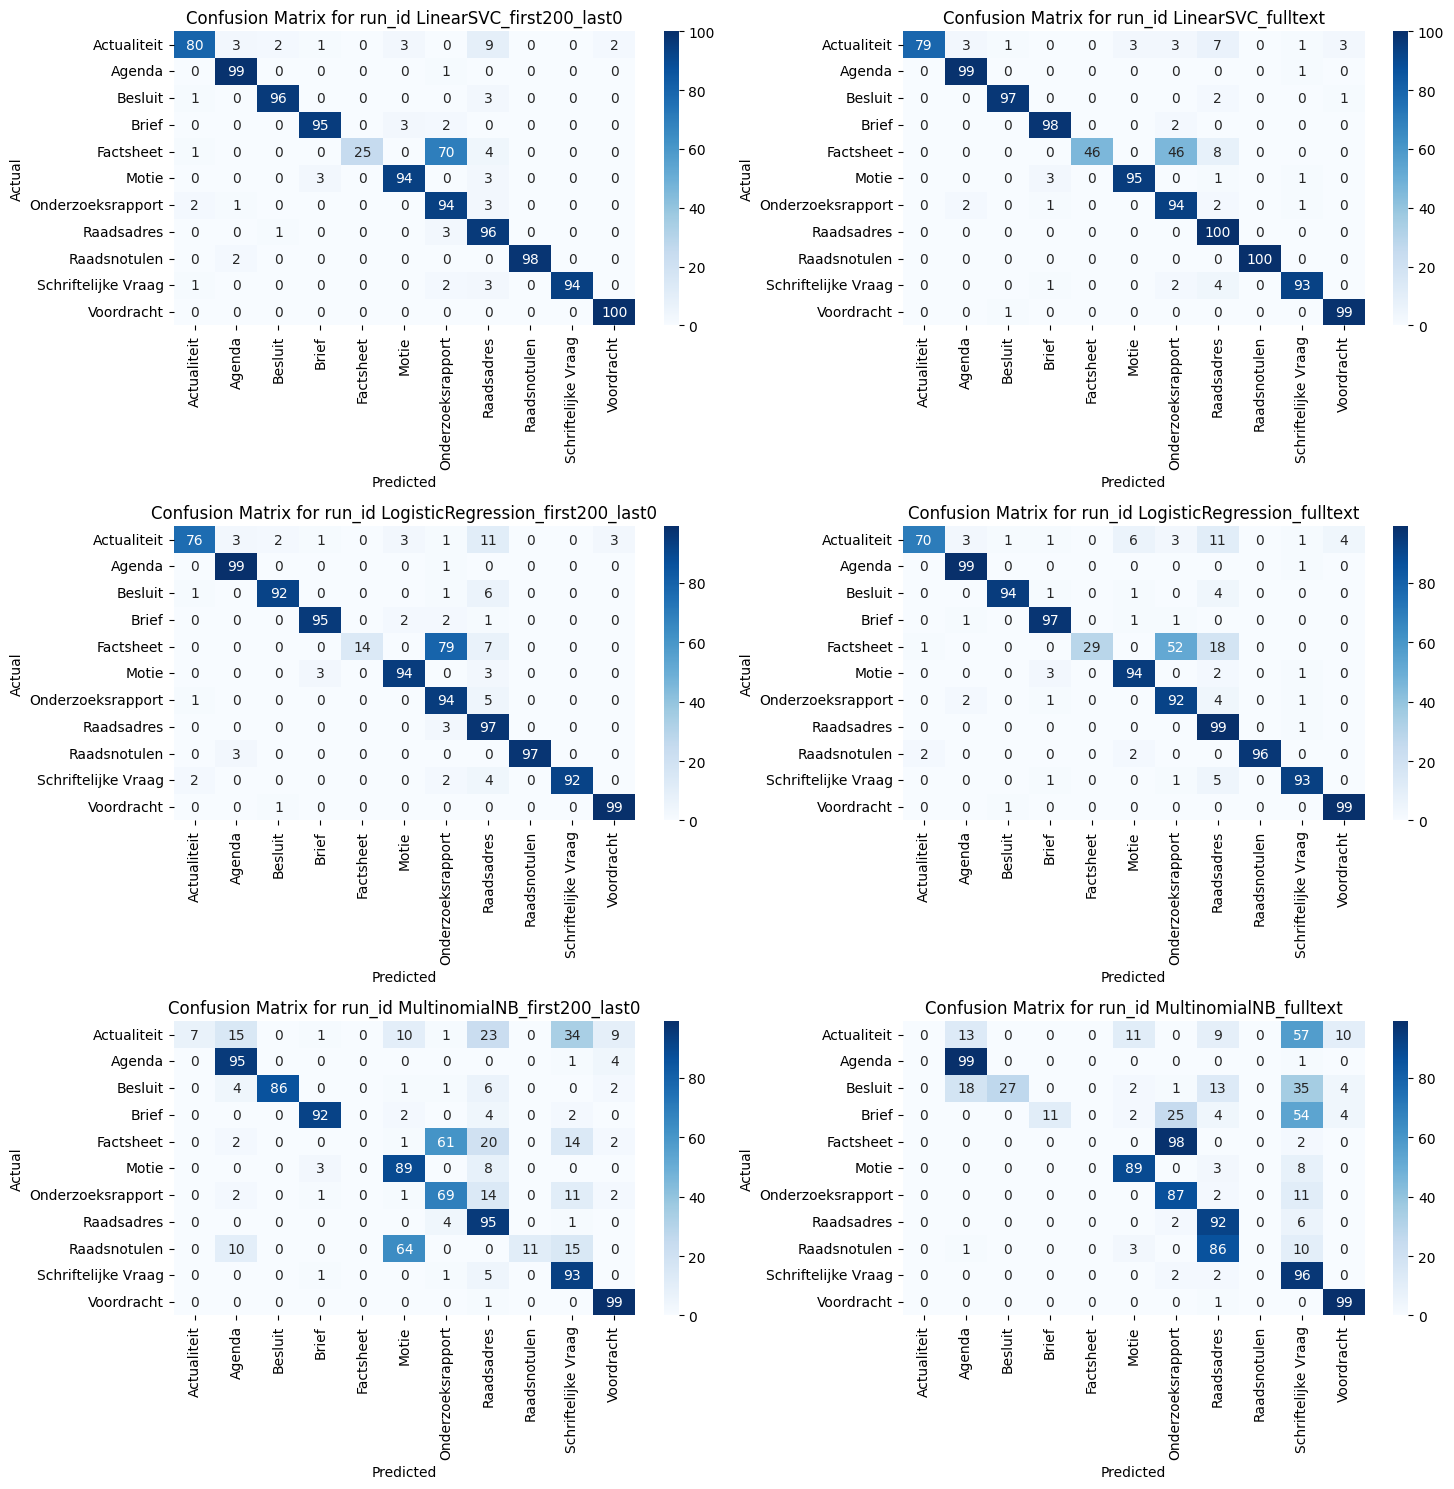

In [6]:
plot_confusion_matrix(pred)

In [7]:
calculate_avg_cos_sim(pred, 'Onderzoeksrapport', 'Factsheet')

LinearSVC_first200_last0: Average cosine similarity between texts of Onderzoeksrapport and Factsheet: 0.053022101041673576
LinearSVC_fulltext: Average cosine similarity between texts of Onderzoeksrapport and Factsheet: 0.04637115991039451
LogisticRegression_first200_last0: Average cosine similarity between texts of Onderzoeksrapport and Factsheet: 0.053022101041673576
LogisticRegression_fulltext: Average cosine similarity between texts of Onderzoeksrapport and Factsheet: 0.04637115991039451
MultinomialNB_first200_last0: Average cosine similarity between texts of Onderzoeksrapport and Factsheet: 0.053022101041673576
MultinomialNB_fulltext: Average cosine similarity between texts of Onderzoeksrapport and Factsheet: 0.04637115991039451


In [12]:
display(pred.loc[(pred['label']=='Factsheet') & (pred['prediction']=='Onderzoeksrapport')])

,path,id,num_pages,MistralTokens,count_MistralTokens,LlamaTokens,count_LlamaTokens,old_label,md5_hash,balanced_split,trunc_txt,trunc_col,label,prediction,model,date,run_id
400,/home/azureuser/cloudfiles/code/blobfuse/raads...,33062,12.0,"[▁g, even, ▁om, <0x0A>, een, ▁ander, <0x0A>, (...",7021,"[▁ge, ven, ▁om, <0x0A>, een, ▁and, er, <0x0A>,...",6681,Factsheets,33c7d551741ebebce0c9ff41eb702f2c,test,geven om\neen ander\n(ru soll\nEr am\nEz nn Mn...,FullText,Factsheet,Onderzoeksrapport,LogisticRegression,2024-05-15 16:06:08.417730+02:00,LogisticRegression_fulltext
402,/home/azureuser/cloudfiles/code/blobfuse/raads...,32940,31.0,"[▁|, ▁AM, STER, D, AM, ▁Z, UID, OO, ST, <0x0A>...",9614,"[▁|, ▁AM, ST, ER, D, AM, ▁Z, UID, O, OST, <0x0...",9401,Factsheets,490748223c082ad69fe718e3076e45f9,test,| AMSTERDAM ZUIDOOST\n | DEMOGRAFIE\n X Demogr...,FullText,Factsheet,Onderzoeksrapport,LogisticRegression,2024-05-15 16:06:08.417730+02:00,LogisticRegression_fulltext
404,/home/azureuser/cloudfiles/code/blobfuse/raads...,32966,3.0,"[▁D, ▁C, AT, ▁t, ▁le, <0x0A>, Am, sterdam, <0x...",4437,"[▁D, ▁C, AT, ▁t, ▁le, <0x0A>, Am, sterdam, <0x...",4361,Factsheets,529400eeca692e60b0e6eaf08bad1973,test,D CAT t le\nAmsterdam\nef Bezoekers in Amsterd...,FullText,Factsheet,Onderzoeksrapport,LogisticRegression,2024-05-15 16:06:08.417730+02:00,LogisticRegression_fulltext
405,/home/azureuser/cloudfiles/code/blobfuse/raads...,33032,6.0,"[▁Ver, ke, er, ▁&, ▁Me, er, ▁V, EN, ▁A, ES, <0...",2259,"[▁Ver, ke, er, ▁&, ▁Me, er, ▁V, EN, ▁A, ES, <0...",2235,Factsheets,90b33128f9bcbe60c9cd30eb6fff2f5c,test,Verkeer & Meer VEN AES\nSamen veilig onderweg\...,FullText,Factsheet,Onderzoeksrapport,LogisticRegression,2024-05-15 16:06:08.417730+02:00,LogisticRegression_fulltext
409,/home/azureuser/cloudfiles/code/blobfuse/raads...,32971,2.0,"[▁er, <0x0A>, de, ▁le, m, ▁O, 0, ▁, 7, <0x0A>,...",3199,"[▁er, <0x0A>, de, ▁lem, ▁O, 0, ▁, 7, <0x0A>, I...",3079,Factsheets,0b45b404c157a71fa54ad67fc8b95ba0,test,"er\nde lem O0 7\nIe Sn, md ZIN ge\nAR\non IS B...",FullText,Factsheet,Onderzoeksrapport,LogisticRegression,2024-05-15 16:06:08.417730+02:00,LogisticRegression_fulltext
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,/home/azureuser/cloudfiles/code/blobfuse/raads...,32983,19.0,"[▁AT, ▁ke, <0x0A>, an, ▁O, RE, ▁|, ▁N, ONE, ▁i...",13044,"[▁AT, ▁ke, <0x0A>, an, ▁O, RE, ▁|, ▁N, ONE, ▁i...",12611,Factsheets,334fa993b9c81f8142c6fcfef1d3d027,test,AT ke\nan ORE | NONE ij Î u.\nHAMER zt ee BEL ...,TruncationLlamaTokensFront200Back0,Factsheet,Onderzoeksrapport,MultinomialNB,2024-05-15 16:03:50.962288+02:00,MultinomialNB_first200_last0
487,/home/azureuser/cloudfiles/code/blobfuse/raads...,32895,20.0,"[▁©, <0x0A>, H, arm, ▁reduction, <0x0A>, works...",14819,"[▁, ©, <0x0A>, H, arm, ▁reduction, <0x0A>, wor...",15425,Factsheets,524d0689b5101c123857a3ebd8557ad6,test,©\nHarm reduction\nworks\nActionable evidence ...,TruncationLlamaTokensFront200Back0,Factsheet,Onderzoeksrapport,MultinomialNB,2024-05-15 16:03:50.962288+02:00,MultinomialNB_first200_last0
489,/home/azureuser/cloudfiles/code/blobfuse/raads...,33018,1.0,"[▁dl, ▁gl, ▁bi, ▁, ®, ▁, ®, ▁, ®, ▁, Í, ▁, ®, ...",1170,"[▁d, l, ▁gl, ▁bi, ▁, ®, ▁, ®, ▁, ®, ▁Í, ▁, ®, ...",1156,Factsheets,fd03041bbc3da62012de16780d288dd3,test,dl gl bi ® ® ® Í ® ® Ik\nRed flags bij crimine...,TruncationLlamaTokensFront200Back0,Factsheet,Onderzoeksrapport,MultinomialNB,2024-05-15 16:03:50.962288+02:00,MultinomialNB_first200_last0
494,/home/azureuser/cloudfiles/code/blobfuse/raads...,32985,1.0,"[▁H, oe, ▁z, iet, ▁de, ▁ro, l, ▁van, ▁bu, urt,...",600,"[▁H, oe, ▁z, iet, ▁de, ▁rol, ▁van, ▁bu, urt, t...",587,Factsheets,1054e2d78197490d2c568d69df0f6c0f,test,Hoe ziet de rol van buurtteam Gaasperdam eruit...,TruncationLlamaTokensFront200Back0,Factsheet,Onderzoeksrapport,MultinomialNB,2024-05-15 16:03:50.962288+02:00,MultinomialNB_first200_last0


In [77]:

# # Compute Jaccard similarity between all pairs of texts
# def jaccard_similarity(text1, text2):
#     set1 = set(text1.split())
#     set2 = set(text2.split())
#     intersection = len(set1.intersection(set2))
#     union = len(set1.union(set2))
#     return intersection / union if union != 0 else 0  # Avoid division by zero

# # Calculate average Jaccard similarity between texts of class 1 and class 2
# total_jaccard_similarity = 0
# num_class1 = len(class1_texts)
# num_class2 = len(class2_texts)

# for text1 in class1_texts:
#     for text2 in class2_texts:
#         total_jaccard_similarity += jaccard_similarity(text1, text2)

# average_jaccard_similarity = total_jaccard_similarity / (num_class1 * num_class2)

# print("Average Jaccard similarity between texts of class 1 and class 2:", average_jaccard_similarity)